In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
import os 
from functions import *
from enrichment import *
from matplotlib_venn import venn2, venn3
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats
import networkx as nx
from scipy.optimize import curve_fit

In [2]:
def func(x, a, b ):
    return a*x + b 

In [3]:
def scatter_linearfit(x,y,ax):
    def func(x, a, b ):
        return a*x + b 
    popt, pcov = curve_fit(func, x, y )
    temp_y = [popt[0]*x[i]+popt[1] for i in range(len(x))]
    ax.scatter(x,y)
    ax.plot(x,temp_y,color='r')
    

# Load dataset

In [4]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])

ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])

In [5]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
all_gene_ids = list(S.index)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
base_level = log_rpkm[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1)

IM_list = list(S.columns)

regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [6]:
IMs = load_pickle('../data/IMdata/imodulon_genes.pkl')
IM_thersholds = {}
for im in IM_list:
    IM_thersholds[im] = compute_threshold(S, im ,cutoff=550)

In [7]:
def save_dict_fasta( seq_dict, out_path ):
    records = []
    for k in seq_dict:
        records.append( SeqRecord(Seq(seq_dict[k]), id = k, name="",description="") )
    SeqIO.write(records, out_path ,"fasta")

In [24]:
def get_sigcorr(reg_gene, im_genes, log_rpkm, G_name ):
    pearsonrs, pvalues = [],[]
    for gene in im_genes:
        coeff, pv = stats.pearsonr( log_rpkm.loc[reg_gene].values, log_rpkm.loc[gene].values )
        pearsonrs.append( coeff )
        pvalues.append( pv )
    temp_pd = pd.DataFrame(zip(im_genes,pearsonrs, pvalues), columns=['gene','coeff','pv'])
    temp_pd = ( temp_pd[temp_pd['pv']<0.05] ).reset_index()
    G=nx.Graph(name = G_name )
    G.add_nodes_from( [(G_name,{'color':'tab:orange'})]+[(v,{'color':'tab:orange'} ) for v in temp_pd['gene']])
    edge_list = []
    for i in range(len(temp_pd.index)):
        weight = list(temp_pd['coeff'])[i]
        if list(temp_pd['coeff'])[i] > 0:
            edge_list.append( (G_name,temp_pd['gene'][i],{'weight':abs(weight)*10,'edgecolor':'tab:red'} ) )
        else:
            edge_list.append( (G_name,temp_pd['gene'][i],{'weight':abs(weight)*10,'edgecolor':'tab:blue'} ) )
    G.add_edges_from(edge_list)
    return G  

# IM-1 case study

In [25]:
im1_promoters=get_im_promoters(IMs['1'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im1_promoters, '../data/MEME_results/im1_promoters.fasta' )

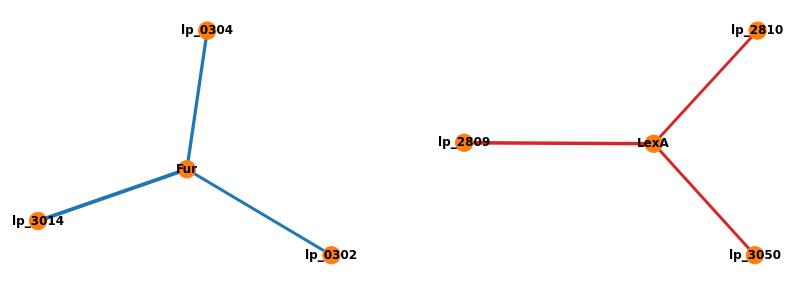

In [26]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
Gs = [get_sigcorr('lp_3247', IMs['1'], log_rpkm, 'Fur' ), get_sigcorr('lp_2063', IMs['1'], log_rpkm, 'LexA' ) ]
for i in range(len(Gs)):
    G = Gs[i]
    nodecolors = [ G.nodes.get(v)['color']for v in G.nodes]
    edgecolors = [G[u][v]['edgecolor'] for u,v in G.edges]
    weights = [G[u][v]['weight'] for u,v in G.edges]
    nx.draw( G,with_labels = True,node_color=nodecolors,font_weight='bold',
            edge_color=edgecolors, width=weights, ax = axs[i])
    
    

# IM-31

In [27]:
im31_promoters=get_im_promoters(IMs['31'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im31_promoters, '../data/MEME_results/im31_promoters.fasta' )

In [28]:
TetR_genes = ['lp_3102','lp_0294','lp_1591','lp_1020','lp_2902','lp_3107','lp_3164',
             'lp_1688','lp_0165','lp_0162','lp_1443','lp_3097','lp_0825','lp_0046','lp_0895',
             'lp_3417','lp_2772','lp_3119','lp_0274','lp_3090','lp_2963','lp_1153','lp_3409',
             'lp_3006','lp_3429','lp_2918']
corr_results={}
for gene in TetR_genes:
    coeff, pv = stats.pearsonr( log_rpkm.loc[gene].values, A.loc[31] )
    if pv < 0.05:
        corr_results[gene] = coeff
print(corr_results)

{'lp_0294': 0.5183695158501247, 'lp_1591': 0.27451790904488105, 'lp_1020': 0.4108139856353391, 'lp_2902': 0.41215066417163204, 'lp_1688': -0.20007440797191758, 'lp_0165': 0.2849346819978528, 'lp_0162': 0.36605797603002105, 'lp_3097': 0.33431011201144795, 'lp_0825': 0.49637323040066916, 'lp_0895': 0.2969903897014524, 'lp_2772': 0.6074169910863859, 'lp_3119': 0.5158504717662618, 'lp_3090': 0.33973998579910175, 'lp_3409': 0.4559062457123816, 'lp_3006': -0.3656306397642657, 'lp_2918': -0.24173023515401906}


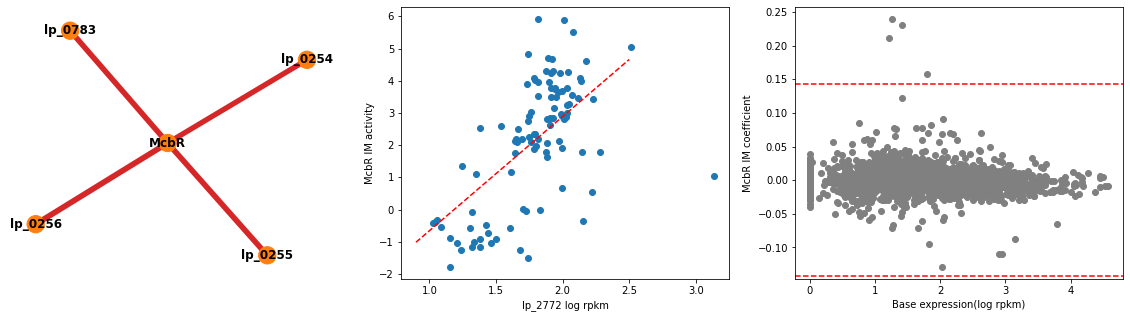

In [29]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
im31_corr = get_sigcorr('lp_2772', IMs['31'], log_rpkm, 'McbR' )
nodecolors = [ im31_corr.nodes.get(v)['color']for v in im31_corr.nodes]
edgecolors = [im31_corr[u][v]['edgecolor'] for u,v in im31_corr.edges]
weights = [im31_corr[u][v]['weight'] for u,v in im31_corr.edges]
nx.draw(im31_corr,with_labels = True,node_color=nodecolors,font_weight='bold',
            edge_color=edgecolors, width=weights,ax = axs[0] )

axs[1].scatter(log_rpkm.loc['lp_2772'],A.loc[31] )
popt, pcov = curve_fit(func, log_rpkm.loc['lp_2772'],A.loc[31] )
x = np.linspace(0.9, 2.5 )
axs[1].plot(x, popt[0]*x+popt[1], color='r',linestyle='--')

axs[1].set_xlabel('lp_2772 log rpkm')
axs[1].set_ylabel('McbR IM activity')


axs[2].scatter(base_level, S['31'], color='grey')
axs[2].set_xlabel('Base expression(log rpkm)')
axs[2].set_ylabel('McbR IM coefficient')
axs[2].axhline(y=IM_thersholds['31'], color='r',linestyle='--')
axs[2].axhline(y=-IM_thersholds['31'], color='r',linestyle='--')

# IM-36

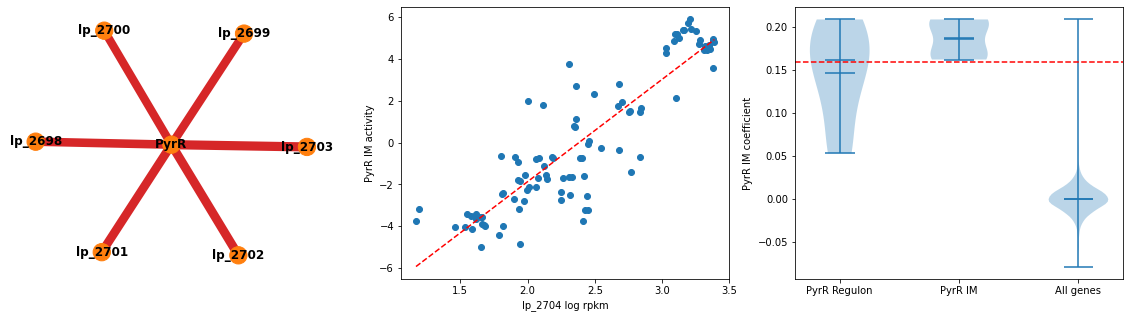

In [30]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
im36_corr = get_sigcorr('lp_2704', IMs['36'], log_rpkm, 'PyrR' )
nodecolors = [ im36_corr.nodes.get(v)['color']for v in im36_corr.nodes]
edgecolors = [im36_corr[u][v]['edgecolor'] for u,v in im36_corr.edges]
weights = [im36_corr[u][v]['weight'] for u,v in im36_corr.edges]
nx.draw(im36_corr,with_labels = True,node_color=nodecolors,font_weight='bold',
            edge_color=edgecolors, width=weights, ax= axs[0])


axs[1].scatter(log_rpkm.loc['lp_2704'],A.loc[36] )
popt, pcov = curve_fit(func, log_rpkm.loc['lp_2704'],A.loc[36] )
x = np.linspace(min(log_rpkm.loc['lp_2704']), max(log_rpkm.loc['lp_2704']) )
axs[1].plot(x, popt[0]*x+popt[1], color='r', linestyle='--')
axs[1].set_xlabel('lp_2704 log rpkm')
axs[1].set_ylabel('PyrR IM activity')


axs[2].violinplot( [ S['36'][ regulons['PyrR'] ], S['36'][ IMs['36'] ],S['36']  ], 
                  showmeans= True, showmedians=True);
labels=['PyrR Regulon', 'PyrR IM','All genes']
axs[2].set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs[2].set_ylabel('PyrR IM coefficient')
axs[2].axhline(y=IM_thersholds['36'], color='r',linestyle='--')

# IM-16 case study

In [31]:
im16_promoters=get_im_promoters(IMs['16'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im16_promoters, '../data/MEME_results/im16_promoters.fasta' )

In [32]:
gntR_genes = ['lp_3558', 'lp_2782', 'lp_0245','lp_2742', 'lp_2615', 'lp_0435','lp_2661','lp_0152',
             'lp_0325','lp_0563','lp_2651','lp_2683','lp_2924','lp_3506','lp_3633','lp_3649']
corr_results={}
for gene in gntR_genes:
    coeff, pv = stats.pearsonr( log_rpkm.loc[gene].values, A.loc[16] )
    if pv < 0.05:
        corr_results[gene] = coeff
print(corr_results)

{'lp_3558': 0.4157919738820236, 'lp_2782': -0.22122028250690776, 'lp_0245': 0.4130858264362418, 'lp_2742': 0.3045644092472091, 'lp_2615': -0.7603699812165278, 'lp_0435': -0.42873683256792466, 'lp_2661': -0.30567143333485713, 'lp_0563': -0.5263297500097027, 'lp_2651': 0.7396193604058265, 'lp_3506': -0.4548137377520035, 'lp_3633': 0.6692691045848196, 'lp_3649': 0.48567937905054426}


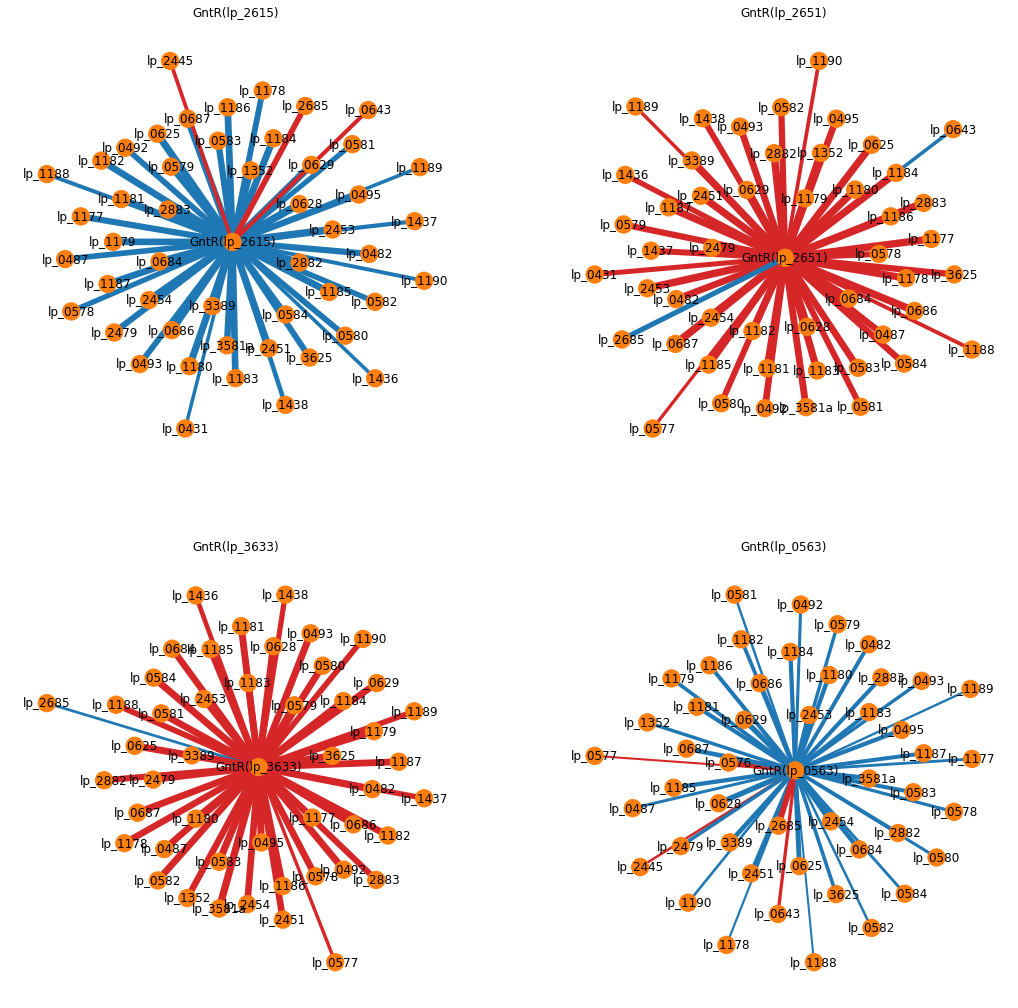

In [37]:
GntR_highcorr = ['lp_2615', 'lp_2651', 'lp_3633','lp_0563']
G_im16 = []
for gene in GntR_highcorr :
    G_im16.append( get_sigcorr(gene, IMs['16'], log_rpkm, 'GntR('+gene+')' ) )
    
fig,axs = plt.subplots(2,2,figsize=(18,18))
for i in range(4):
    x,y = int(i/2), int(i%2)
    G = G_im16[i]
    nodecolors = [ G.nodes.get(v)['color']for v in G.nodes]
    edgecolors = [ G[u][v]['edgecolor'] for u,v in G.edges]
    weights = [G[u][v]['weight'] for u,v in G.edges]
    nx.draw(G,with_labels = True,node_color=nodecolors,
            edge_color=edgecolors, width=weights, ax = axs[x][y])
    axs[x][y].set_title(G.name)

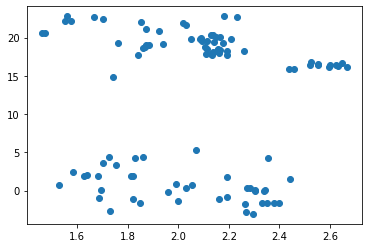

In [14]:
plt.scatter(log_rpkm.loc['lp_0152'],A.loc[16])